# Red de empresas - Colaboraciones en contratos
__Mariana Esther Martínez Sánchez__

## Cargar datos

In [1]:
import pandas as pd
import networkx as nx

from utils import clean_string
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3

from IPython.display import display

In [2]:
colors = {'FOX':'red','CAL':'green','EPN':'blue'}
n_display = 10

consorcios = {}
for pres in ['FOX','CAL','EPN']:
    data = pd.read_csv('data-clean/{}-contratos.csv'.format(pres))
    data = data['consorcio'].to_list()
    data = [d.split(';') if type(d)==str else '' for d in data ]
    data = [[clean_string(s) for s in d] for d in data]
    data = [list(set(d)) for d in data]
    consorcios[pres] = data
    data = None
print("Contratos por sexenio")
print([(i,len(j)) for i,j in consorcios.items()])

Contratos por sexenio
[('FOX', 138462), ('CAL', 549162), ('EPN', 452369)]


## ¿Cuántos contratos se dieron a empresas o consorcios?

El sexenio donde se dieron mas contratos fue el de Caldreon, seguido por EPN y FOX.
En el sexenio de Fox se dió el 26% de los contratos a consorcios

In [3]:
df = pd.DataFrame(index=consorcios.keys())
for key in consorcios.keys():
    d = [len(i) for i in consorcios[key]]
    #Total
    df.loc[key,'Contratos'] = len(d)
    #Empresas van solas
    singletons = int(d.count(1))
    df.loc[key,'Empresas solas'] = singletons
    #Consorcios
    df.loc[key,'Consorcios'] = len(d)-singletons
    # % empresas
    df.loc[key,'% empresas solas'] = round(singletons / len(d) ,3)
    # % empresas
    df.loc[key,'% consorcios'] = round(1 - singletons / len(d) ,3)
df

,Contratos,Empresas solas,Consorcios,% empresas solas,% consorcios
FOX,138462.0,102232.0,36230.0,0.738,0.262
CAL,549162.0,518996.0,30166.0,0.945,0.055
EPN,452369.0,433522.0,18847.0,0.958,0.042


## ¿Cuántas empresas han tenido contratos con el gobierno en los tres sexenios?

El número de las empresas que tienen contratos ha crecido con cada administración.
La mayor parte de las empresas trabajan para una sola administración.
Pero hay 6040 empresas que han tenido contratos con las tres administraciones.

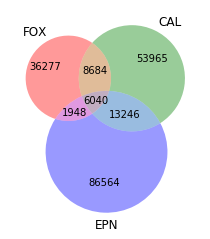

In [4]:
unnest = {key:set([item for sublist in value for item in sublist]) for key,value in consorcios.items()}
venn3( unnest.values(), set_labels=unnest.keys() )
plt.show()
unnest = None

## ¿Cúal es el tamaño de los consorcios?

La mayor parte de los consorios son de cuatro empresas.
En general el tamaño de los consorcios en el sexenio de Fox y Calderon es similar.
Sin embargo, en el sexenio de EPN, aunque hubo menos consorcios, estos crecieron de tamaño.  
En ese sexenio hubo trece consorcios de mas de cién empresas, llegando a haber un consorcio de 1910 empresas

In [5]:
df = pd.DataFrame(index=consorcios.keys())
for key in consorcios.keys():
    d = [len(i) for i in consorcios[key]]
    d = [i for i in d if i>1]
    #Consorcios promedio
    df.loc[key,'Tamaño promedio'] = round(sum(d)/len(d),3)
    #Consorcios mas grande
    df.loc[key,'Tamaño máximo'] = max(d)
    #Consorcios mas grande
    df.loc[key,'Tamaño mayor a cién'] = len([i for i in d if i>=100])
df

,Tamaño promedio,Tamaño máximo,Tamaño mayor a cién
FOX,4.596,108.0,6.0
CAL,3.723,103.0,2.0
EPN,4.774,1910.0,13.0


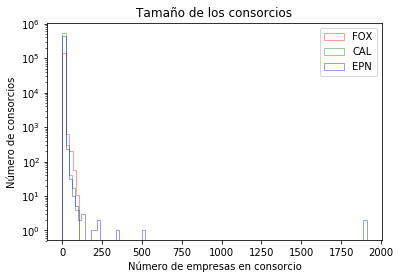

In [6]:
for key in consorcios.keys():
    d = [len(i) for i in consorcios[key]]
    sns.distplot(d, bins=round(max(d)/20), kde=False, label=key, 
                 hist_kws={"histtype":"step", "color":colors[key]})
plt.title("Tamaño de los consorcios")
plt.xlabel("Número de empresas en consorcio")
plt.ylabel("Número de consorcios")
plt.yscale('log')
plt.legend()
plt.show()

## ¿Qué empresas participan mas en consorcios?

Existe un grupo de empresas de productos médicos que participan en un gran número de consorcios durante las tres administraciones

In [7]:
def crear_red(data):
    """
    Toma una lista de consorcios y construye una red
    
    G = crear_red(['a','abc','b','cb','a'])
    G.nodes(data=True), G.edges(data=True)
    """
    G = nx.Graph()
    for contrato in data:
        #add nodes
        for empresa in contrato:
            if not G.has_node(empresa):
                G.add_node(empresa, contratos=0, consorcios=0)
            G.nodes[empresa]['contratos'] += 1
        #add edges
        if len(contrato)>1:
            for empresa in contrato:
                G.nodes[empresa]['consorcios'] += 1
            for s,t in combinations(contrato,2):
                if G.has_edge(s,t): G.edges[s,t]['colaboraciones'] += 1
                else: G.add_edge(s,t,colaboraciones=1)
    for empresa in G.nodes():
        G.nodes[empresa]['% consorcios'] = round(G.nodes[empresa]['consorcios']/G.nodes[empresa]['contratos'],3)
    return G

In [8]:
red = {}
for key, value in consorcios.items():
    print(key, len(value))
    red[key] = {}
    red[key]['red'] = crear_red(consorcios[key])
    red[key]['df_nodes'] = pd.DataFrame([i[1] for i in red[key]['red'].nodes(data=True)], 
                                        index=[i[0] for i in red[key]['red'].nodes(data=True)])
    

FOX 138462
CAL 549162
EPN 452369


Empresas que participan en mas consorcios

In [9]:
for key in consorcios.keys():
    print(key)
    display(red[key]['df_nodes'].sort_values('consorcios', ascending=False).head(n_display))

FOX


,contratos,consorcios,% consorcios
Selecciones Medicas Sa De Cv,1447,1325,0.916
Farmaceuticos Maypo Sa De Cv,1278,1113,0.871
Farmacos Especializados Sa De Cv,1360,1062,0.781
Laboratorios Pisa Sa De Cv,1150,1014,0.882
Baxtersa De Cv,921,867,0.941
Ralca Sa De Cv,797,756,0.949
Distribuidora Inter De Medic Y Eq Medico Sa De Cv,688,688,1.000
Representaciones E Investigaciones Medicas Sa De Cv,700,673,0.961
Savi Distribuciones Sa De Cv,668,633,0.948
Servicios Medicos Super Sa De Cv,652,628,0.963


CAL


,contratos,consorcios,% consorcios
Farmaceuticos Maypo Sa De Cv,1609,703,0.437
Grupo Farmacos Especializados Sa De Cv,913,525,0.575
Laboratorios Pisa Sa De Cv,1465,441,0.301
Ralca Sa De Cv,578,378,0.654
Comercializadora Damag Sa De Cv,394,326,0.827
Selecciones Medicas Del Centro Sa De Cv,467,323,0.692
Equipos Electricos Para Alta Tension Sa De Cv,747,313,0.419
Control Tecnico Y Representaciones,259,253,0.977
Degasa Sa De Cv,411,247,0.601
Potencia Distribucion Servicios Sa De Cv,299,235,0.786


EPN


,contratos,consorcios,% consorcios
Distribuidora Internacional De Medicamentos Y Equipo Medico Sa De Cv,1736,1203,0.693
Grupo Farmacos Especializados Sa De Cv,2015,1196,0.594
Farmaceuticos Maypo Sa De Cv,2160,865,0.400
Total Farma Sa De Cv,791,641,0.810
Medicamentos Y Servicios Integrales Del Noroeste Sa De Cv,639,567,0.887
Comercializadora Arvien Sa De Cv,619,542,0.876
Bioma Farmaceutica Sa De Cv,573,526,0.918
Ralca Sa De Cv,749,462,0.617
Holiday De Mexico Sa De Cv,490,455,0.929
Corporacion Armo Sa De Cv,507,435,0.858


Empresas que participan principalmente en consorcios

In [10]:
for key in consorcios.keys():
    print(key)
    df = red[key]['df_nodes']
    display(df[df['consorcios']>1].sort_values(['% consorcios','consorcios'], ascending=False).head(n_display))

FOX


,contratos,consorcios,% consorcios
Distribuidora Inter De Medic Y Eq Medico Sa De Cv,688,688,1.0
Laboratorios Valdecasas Sa,333,333,1.0
Codifarma Sa De Cv,286,286,1.0
Audipharma Sa De Cv,256,256,1.0
Importadora Y Manufacturera Bruluart Sa,243,243,1.0
Intercontinental De Medicamentos Sa De Cv,229,229,1.0
Esigar Quirurgica Sa De Cv,218,218,1.0
Buffingtons De Mexico Sa De Cv,189,189,1.0
Medicel Sa De Cv,185,185,1.0
Laboratorios Alpharma Sa De Cv,179,179,1.0


CAL


,contratos,consorcios,% consorcios
Davlu Distribuidora Sa De Cv,76,76,1.0
Organizacion Papelera Mexicana Sadecv,71,71,1.0
Distribuidora Labhos S A De Cv,67,67,1.0
Proveddora Nacional De Material De Curacion Sa De Cv,65,65,1.0
Distribuidora Inter De Medic Y Eq Medico Sa De Cv,65,65,1.0
Cia Reamex Sa De Cv,52,52,1.0
Electramex Sa De Cv,51,51,1.0
Anuncios Impresiones Y Soluciones Sa De Cv,51,51,1.0
Francisco Garcia Sa De Cv,44,44,1.0
Manuel Alonso Corporacion Sa De Cv,44,44,1.0


EPN


,contratos,consorcios,% consorcios
Corporativo De Materiales Avalsan S A De C V,68,68,1.0
Mex Ray Sa De Cv,55,55,1.0
Carmen De La Madrid Hernandez,54,54,1.0
Miguel Camacho Arreola,46,46,1.0
Xochitl Cecilia Rosas Barreda,38,38,1.0
Norma Ediciones Sa De Cv,34,34,1.0
Ediciones Larousse,33,33,1.0
Macmillan Publishers Sa De Cv,33,33,1.0
Ud Publishing Sa De Cv,33,33,1.0
Distribuidora Farmaceutica Y Hospitalaria Del Sur,32,32,1.0


## ¿Qué empresas van juntas en los consorcios?

In [11]:
for key in consorcios.keys():
    print(key)
    df_edges = nx.to_pandas_edgelist(red[key]['red'], source="empresa 1", target="empresa 2")
    display(df_edges.sort_values('colaboraciones', ascending=False).head(n_display))

FOX


,empresa 1,empresa 2,colaboraciones
13843,Farmacos Especializados Sa De Cv,Farmaceuticos Maypo Sa De Cv,700
15202,Selecciones Medicas Sa De Cv,Farmaceuticos Maypo Sa De Cv,683
13832,Farmacos Especializados Sa De Cv,Selecciones Medicas Sa De Cv,677
17360,Laboratorios Pisa Sa De Cv,Farmaceuticos Maypo Sa De Cv,615
22316,Ralca Sa De Cv,Farmaceuticos Maypo Sa De Cv,580
15196,Selecciones Medicas Sa De Cv,Ralca Sa De Cv,562
15193,Selecciones Medicas Sa De Cv,Laboratorios Pisa Sa De Cv,561
13837,Farmacos Especializados Sa De Cv,Ralca Sa De Cv,526
6645,Distribuidora Inter De Medic Y Eq Medico Sa De Cv,Selecciones Medicas Sa De Cv,521
24276,Farmaceuticos Maypo Sa De Cv,Representaciones E Investigaciones Medicas Sa ...,520


CAL


,empresa 1,empresa 2,colaboraciones
4192,Grupo Farmacos Especializados Sa De Cv,Farmaceuticos Maypo Sa De Cv,330
1572,Ralca Sa De Cv,Farmaceuticos Maypo Sa De Cv,266
1568,Ralca Sa De Cv,Grupo Farmacos Especializados Sa De Cv,244
2693,Laboratorios Pisa Sa De Cv,Farmaceuticos Maypo Sa De Cv,208
4293,Grupo Farmacos Especializados Sa De Cv,Selecciones Medicas Del Centro Sa De Cv,190
5433,Farmaceuticos Maypo Sa De Cv,Selecciones Medicas Del Centro Sa De Cv,162
2689,Laboratorios Pisa Sa De Cv,Grupo Farmacos Especializados Sa De Cv,160
1565,Ralca Sa De Cv,Laboratorios Pisa Sa De Cv,143
5432,Farmaceuticos Maypo Sa De Cv,Daltem Provee Nacional Sa De Cv,137
1716,Ralca Sa De Cv,Selecciones Medicas Del Centro Sa De Cv,133


EPN


,empresa 1,empresa 2,colaboraciones
12484,Farmaceuticos Maypo Sa De Cv,Grupo Farmacos Especializados Sa De Cv,453
36726,Distribuidora Internacional De Medicamentos Y ...,Grupo Farmacos Especializados Sa De Cv,393
10931,Ralca Sa De Cv,Grupo Farmacos Especializados Sa De Cv,259
10920,Ralca Sa De Cv,Farmaceuticos Maypo Sa De Cv,225
36798,Distribuidora Internacional De Medicamentos Y ...,Total Farma Sa De Cv,206
12479,Farmaceuticos Maypo Sa De Cv,Distribuidora Internacional De Medicamentos Y ...,198
39545,Grupo Farmacos Especializados Sa De Cv,Total Farma Sa De Cv,172
36802,Distribuidora Internacional De Medicamentos Y ...,Marcas Nestle,149
94967,Gluck Chemistry S De Rl De Cv,Cyo Factory Sa De Cv,149
39549,Grupo Farmacos Especializados Sa De Cv,Marcas Nestle,130


## ¿Cuál es el tamaño de los grupos de colaboración?

FOX
	Grupos de colaboración:  1288
	Grupo mas grande:  23684
	Promedio sin grupo mas grande 2.466
CAL
	Grupos de colaboración:  2053
	Grupo mas grande:  14623
	Promedio sin grupo mas grande 2.728
EPN
	Grupos de colaboración:  1229
	Grupo mas grande:  14237
	Promedio sin grupo mas grande 4.165


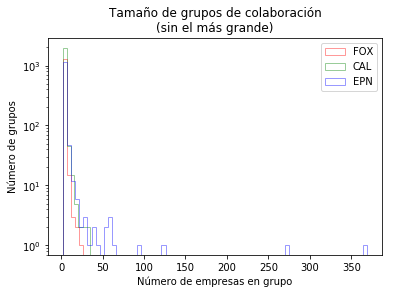

In [12]:
for key in consorcios.keys():
    print(key)
    G = red[key]['red']
    subG = [G.subgraph(c) for c in nx.connected_components(G) if len(G.subgraph(c))>1]
    d = [len(g) for g in subG]
    print("\tGrupos de colaboración: ", len(d))
    print("\tGrupo mas grande: ", max(d))
    d.remove(max(d))
    print('\tPromedio sin grupo mas grande', round(sum(d)/len(d),3))
    sns.distplot(d, bins=round(max(d)/5), kde=False, label=key, 
                 hist_kws={"histtype":"step", "color":colors[key]})
    G, subG = None, None
plt.title("Tamaño de grupos de colaboración\n(sin el más grande)")
plt.xlabel("Número de empresas en grupo")
plt.ylabel("Número de grupos")
plt.yscale('log')
plt.legend()
plt.show()

## ¿Cuales son los grupos que mas colaboran?

Gráficamos el grupo de empresas mas grande que comparte minímo 150 colaboraciones entre ellas

FOX
	Empresas: 29 	Componentes: 2


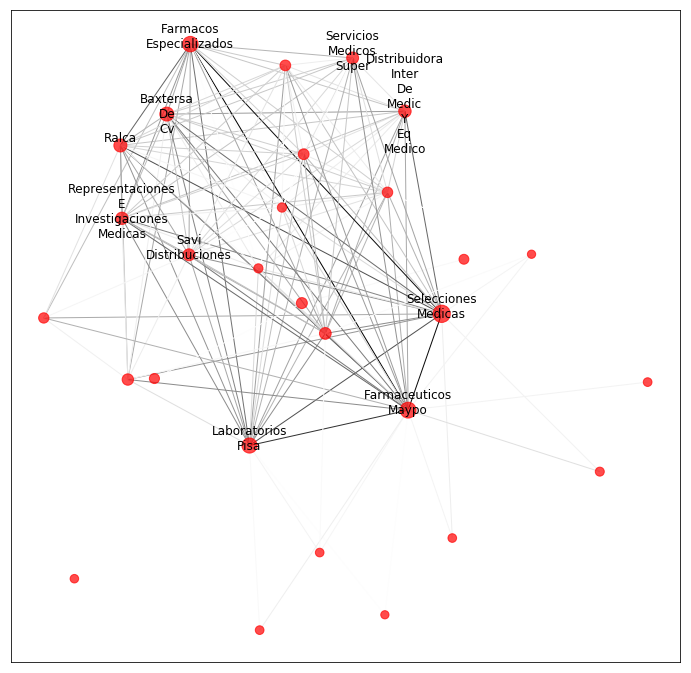

CAL
	Empresas: 65 	Componentes: 8


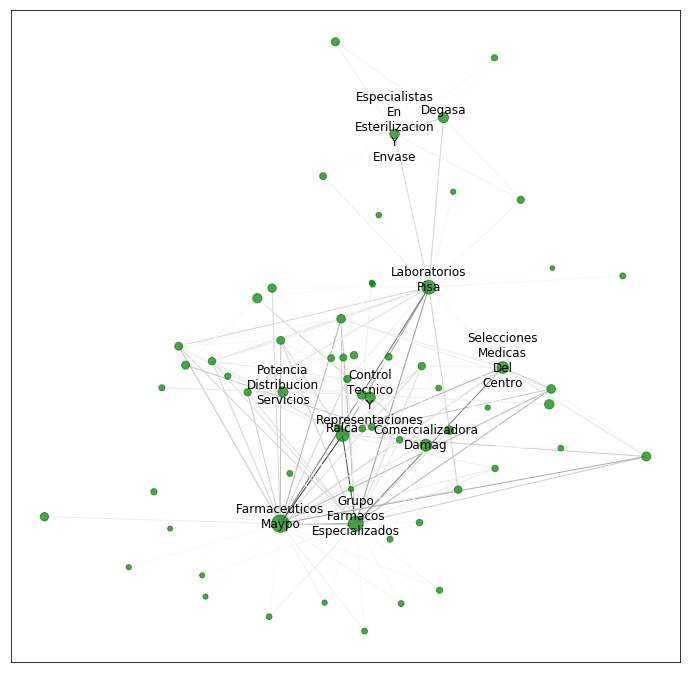

EPN
	Empresas: 51 	Componentes: 2


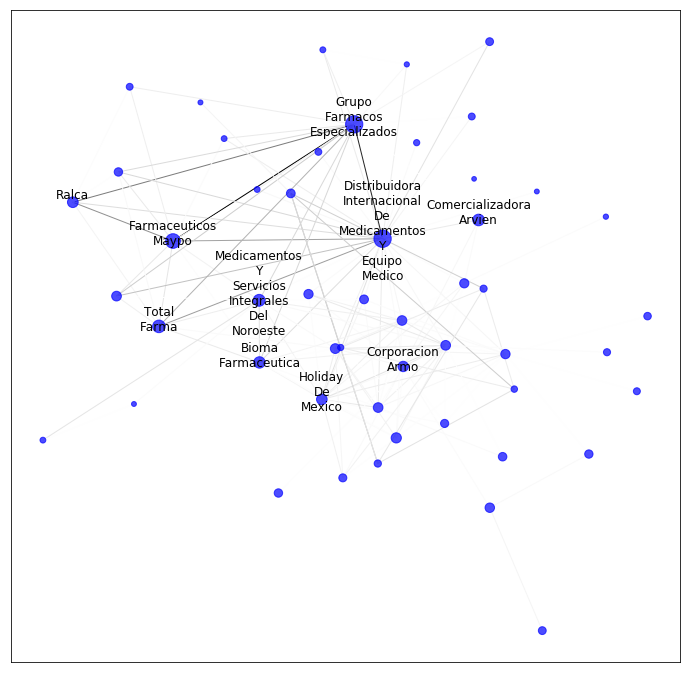

In [18]:
thr_max = 150
for key in consorcios.keys():
    print(key)
    G = red[key]['red']
    print('\tEmpresas:', len(G.nodes()), 
          "\tComponentes:", nx.number_connected_components(G))
    
    remove = sorted(G.edges(data=True), key=lambda t: t[2].get('colaboraciones', 1), reverse=True)[thr_max:]
    G.remove_edges_from(remove)
    G.remove_nodes_from(list(nx.isolates(G)))
    plt.figure(figsize=(12,12))
    pos = nx.kamada_kawai_layout(G, weight='colaboraciones')
    node_size = [a['consorcios'] for n,a in G.nodes(data=True)]
    node_size = [int(n*300/max(node_size)) for n in node_size]
    nx.draw_networkx_nodes(G,pos,node_color=colors[key], node_size=node_size, alpha=0.7)
    edge_color = [a['colaboraciones'] for s,t,a in G.edges(data=True)]
    nx.draw_networkx_edges(G,pos, edge_color=edge_color, edge_cmap=plt.cm.binary)
    top_nodes = sorted(G.nodes(data=True), key=lambda t: t[1].get('consorcios', 1), reverse=True)[0:10]
    top_nodes = [n[0] for n in top_nodes]
    node_label = [n.replace('Sa De Cv','').replace(' ','\n') 
                  if n in top_nodes else '' for n in G.nodes()]
    node_label = {k:v for k,v in zip(G.nodes(),node_label)}
    nx.draw_networkx_labels(G, pos, node_label)
    plt.show()